# **Retrieval Augmented Generation (RAG) 애플리케이션 구축: Part 2**

많은 Q&A 애플리케이션에서는 **사용자와의 대화가 이어질 수 있도록** 설계해야 합니다.  
이를 위해서는 애플리케이션이 과거의 **질문과 답변을 기억(메모리)** 하고, 이를 현재의 논리적 흐름에 통합하는 기능이 필요합니다.

###  **대화 기록(Chat History) 관리**

여기서는 **과거 대화 기록을 현재 답변 논리에 통합하는 방법**을 중점적으로 다룹니다.  

### **두 가지 접근 방식**

1. **체인(Chains)**   - 최대 한 번의 검색 단계만 실행합니다.  

2. **에이전트(Agents)**   - LLM이 필요에 따라 **여러 번의 검색 단계 (다중 단계 검색)** 를 수행하도록 자유롭게 설정합니다.

In [1]:
# !pip install -qU \
# python-dotenv \
# langchain \
# langchain-community \
# openai \
# anthropic \
# langchain-openai \
# langchain-anthropic \
# langchain-google-genai \
# python-dotenv
# !pip install --upgrade --quiet langgraph langchain-community beautifulsoup4

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
# LangChain 추적(Tracing) 설정 활성화
os.environ["LANGCHAIN_TRACING_V2"] = "true"

In [4]:
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

# 사용할 언어 모델의 이름을 지정
llm = ChatOpenAI(model="gpt-4o-mini")
# 사용할 임베딩 모델의 이름을 지정
embeddings = OpenAIEmbeddings(model='text-embedding-3-small')

In [5]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
vector_store

Lilian Weng의 블로그 게시물 "[LLM 기반 자율 에이전트](https://lilianweng.github.io/posts/2023-06-23-agent/)"의 내용을 인덱싱한 벡터 스토어를 활용하여 사용자의 질문에 대한 관련 정보를 효과적으로 검색하고 제공할 수 있습니다.

In [15]:
import bs4
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing_extensions import List, TypedDict

# HTML에서 `post-content`, `post-title`, `post-header` 클래스를 가진 콘텐츠만 추출하여 텍스트 변환
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))

# WebBaseLoader를 사용해 웹 페이지의 내용을 불러옵니다.
# Define the headers with a User-Agent
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)

# 문서 로드하여 Document 객체 목록 반환
docs = loader.load()

# 로드된 문서가 정확히 하나인지 검증합니다.
assert len(docs) == 1

# 웹 페이지에서 데이터를 로드
# 텍스트를 작은 청크로 분할
# - chunk_size: 각 청크의 최대 문자 수 (1000자)
# - chunk_overlap: 청크 간 겹치는 문자 수 (200자)
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)

# 로드된 문서를 청크로 나누고 리스트로 반환
all_splits = text_splitter.split_documents(docs)

# 분할된 청크(서브 문서)의 개수 출력
print(f"블로그 글을 {len(all_splits)}개의 하위 문서로 분할했습니다.")

블로그 글을 66개의 하위 문서로 분할했습니다.


In [16]:
# 텍스트 청크를 벡터 스토어에 인덱싱
# - vector_store: 텍스트 임베딩 벡터를 저장하고 검색하는 데 사용되는 데이터 저장소입니다.
_ = vector_store.add_documents(documents=all_splits)

### 기존 방식: 상태(state) 기반 접근법 
- **RAG 애플리케이션**에서는 사용자 입력, 검색된 문서, 그리고 생성된 답변을 각각 상태(state)라는 구조 안에 별도의 키(key)로 저장했습니다.  
- 예를 들면:  
   ```python
   state = {
       "question": "고양이는 몇 살까지 살아요?",
       "context": ["고양이의 평균 수명은 12-18년입니다."],
       "answer": "고양이는 보통 12-18년 정도 삽니다."
   }
   ```
- 하지만 이런 방식은 **대화의 흐름을 자연스럽게 표현하기 어려울 수 있습니다.**  

---

### 새로운 방식: 메시지(messages) 기반 접근법
- 사람들은 대화를 할 때 메시지 시퀀스(sequence of messages)를 주고받습니다.  
- **메시지 방식**은 사용자와 어시스턴트 간의 대화를 보다 **자연스럽고 직관적으로 표현**합니다.  
- 여기에는 다음과 같은 요소들이 포함됩니다:  
   1. **사용자 메시지(User Message):** 사용자의 질문이나 요청  
   2. **어시스턴트 메시지(Assistant Message):** AI가 생성한 답변  
   3. **도구 메시지(Tool Message):** 검색된 문서나 기타 참고 자료  

---

### 왜 메시지 방식이 더 나은가? 
- **더 직관적:** 실제 대화처럼 시간 순서대로 메시지를 쌓아올립니다.  
- **유연함:** 검색된 문서나 외부 도구의 결과도 **메시지 형태**로 자연스럽게 추가할 수 있습니다.  
- **일관성 유지:** AI가 맥락을 유지하면서 이전 대화와의 연관성을 이해하기 쉽습니다.  

---

#### **새로운 메시지(messages) 방식:**
```python
messages = [
    {"role": "user", "content": "고양이는 몇 살까지 살아요?"},
    {"role": "tool", "content": "검색 결과: 고양이의 평균 수명은 12-18년입니다."},
    {"role": "assistant", "content": "고양이는 보통 12-18년 정도 삽니다."}
]
```
---

**즉, 메시지 방식은 RAG 애플리케이션을 더 자연스럽고 직관적으로 만들기 위한 개선된 표현 방식입니다.**  

**도구 호출(tool-calling)** 을 활용해 검색 단계와 상호작용하는 것에는 또 다른 이점이 있습니다. 바로 **검색에 사용할 쿼리를 모델이 직접 생성할 수 있다는 점**입니다.  

이것은 특히 **대화형 환경(conversational setting)** 에서 중요합니다. 사용자의 질문이 **대화 이력(chat history)** 을 기반으로 문맥화되어야 할 수 있기 때문입니다.  

---

### **예시 대화**  

> **Human:** "Task Decomposition이란 무엇인가요?"  
> **AI:** "Task Decomposition은 복잡한 작업을 더 작고 단순한 단계로 나누어, 에이전트나 모델이 더 쉽게 관리할 수 있도록 만드는 과정입니다."  
> **Human:** "일반적으로 Task Decomposition을 수행하는 방법에는 어떤 것들이 있나요?"  

- 이 시나리오에서 모델은 `"Task Decomposition의 일반적인 접근법"`과 같은 검색 쿼리를 생성할 수 있습니다.  
- **도구 호출(tool-calling)** 은 이런 과정을 자연스럽게 지원합니다.  

---

### **도구 호출의 장점**  

1. **쿼리 최적화(Query Optimization)**  
   - 모델은 사용자 입력을 더 효과적인 검색 쿼리로 **재작성(rewrite)** 할 수 있습니다.   
<p></p>
2. **대화 이력(Contextualization)**  
   - 모델은 대화 기록을 활용해 사용자 질문을 더 명확한 검색어로 변환할 수 있습니다.  
<p></p>
3. **직접 응답 지원**  
   - 검색 단계가 필요 없는 질문(예: "Hello!"와 같은 인사말)에 대해 바로 응답할 수 있습니다.  

이제 검색 단계를 **도구(tool)** 로 전환해 보겠습니다. 이렇게 하면 모델이 검색을 더 자연스럽고 효율적으로 수행할 수 있습니다.  

- response_format="content_and_artifact : 이 설정은 도구의 출력이 두 부분으로 구성됨을 나타냅니다:  
    콘텐츠(content): 모델이 처리할 수 있는 문자열 형태의 요약 또는 설명입니다.  
    아티팩트(artifact): 모델 외부에서 사용될 실제 데이터나 객체입니다.

In [17]:
from langchain_core.tools import tool

# 검색(retrieve) 함수를 도구로 정의
# - response_format="content_and_artifact": 결과를 콘텐츠(content)와 아티팩트(artifact)로 반환
@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """
    주어진 쿼리와 관련된 정보를 검색합니다.
    - query: 검색할 텍스트 쿼리입니다.
    """    
    # 벡터 스토어에서 유사도 검색 수행. 가장 유사한 두 개의 문서를 반환.
    retrieved_docs = vector_store.similarity_search(query, k=2)
    
    # 검색된 문서를 문자열로 직렬화
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content {doc.page_content}")
        for doc in retrieved_docs
    )
    
    # 직렬화된 결과(content)와 원본 문서 목록(artifact) 반환.
    return serialized, retrieved_docs

```
# serialized 예시
class Doc:
    def __init__(self, metadata, page_content):
        self.metadata = metadata
        self.page_content = page_content

retrieved_docs = [
    Doc(metadata="Document 1", page_content="This is the first document."),
    Doc(metadata="Document 2", page_content="This is the second document.")
]

serialized = "\n\n".join(
    f"Source: {doc.metadata}\nContent: {doc.page_content}"
    for doc in retrieved_docs
)

print(serialized)
```

### **대화 기록(chat history)의 상태(Stateful) 관리**

1. 애플리케이션을 컴파일할 때 **[체크포인터(checkpointer)](https://langchain-ai.github.io/langgraph/concepts/persistence/)** 를 설정합니다.  그래프의 각 노드가 상태(state)에 메시지를 추가하기 때문에,    **호출(invocation)** 이 반복되어도 일관된 **대화 기록(chat history)** 이 유지됩니다.

2. LangGraph에는 간단한 **인메모리 체크포인터(In-memory Checkpointer)** 가 내장되어 있습니다.  

In [18]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

## **에이전트(Agents)**

**에이전트(Agents)** 는 **대규모 언어 모델(LLMs)의 추론 능력(reasoning capabilities)** 을 활용하여 실행 중에 의사 결정을 내릴 수 있도록 합니다.  

에이전트를 사용하면 **검색(retrieval) 프로세스의 일부 권한을 모델에 위임**할 수 있습니다.  

- **체인(chain)** 방식보다 예측 가능성은 떨어질 수 있지만,  
- **여러 번의 검색 단계**를 실행하거나,  
- **단일 검색을 반복적으로 수행**할 수 있습니다.

---

### **간단한 RAG ReAct 에이전트 구성**
  
**LangGraph**의 [**사전 구축된 ReAct 에이전트 생성자(pre-built ReAct agent constructor)**](https://langchain-ai.github.io/langgraph/how-tos/#langgraph.prebuilt.chat_agent_executor.create_react_agent)를 사용하면, 한 줄의 코드로 이를 구현할 수 있습니다.

---

In [19]:
from langgraph.prebuilt import create_react_agent  # 사전 구축된 ReAct 에이전트 생성자

# ReAct 에이전트 생성
# - [retrieve]: 에이전트가 사용할 도구 목록입니다.
# - checkpointer=memory: 상태(대화 기록 등)를 메모리에 저장.
agent_executor = create_react_agent(
    llm, 
    [retrieve], 
    checkpointer=memory
)

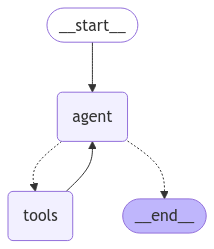

In [20]:
from IPython.display import Image, display

display(Image(agent_executor.get_graph().draw_mermaid_png()))

**도구 호출(tool invocation)** 이 원래 LLM 호출로 다시 돌아갑니다. 

- 모델은 검색된 문맥을 사용해 **질문에 답변**할 수도 있고,  
- 더 많은 정보를 얻기 위해 **다른 도구 호출(tool call)** 을 생성할 수도 있습니다.  

이제 일반적으로 **여러 단계의 반복적 검색(retrieval steps)** 이 필요한 질문을 만들어 테스트해 봅니다.

In [23]:
config = {"configurable": {"thread_id": "def234"}}

# tools 호출이 필요 없는 query
input_message = (
    "안녕? 내 이름은 길동이야" 
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

안녕? 내 이름은 길동이야
================================== Ai Message ==================================

안녕하세요, 길동님! 만나서 반갑습니다. 무엇을 도와드릴까요?


In [24]:
# tools 호출이 필요한 query
input_message = (
    "Task Decomposition의 표준 방법은 무엇인가요??\n\n"
    "답변을 얻은 후, 해당 방법의 일반적인 확장 방법들을 찾아보세요."  
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Task Decomposition의 표준 방법은 무엇인가요??

답변을 얻은 후, 해당 방법의 일반적인 확장 방법들을 찾아보세요.
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_fmAl2r5eelGJIMjdMWiBDGoa)
 Call ID: call_fmAl2r5eelGJIMjdMWiBDGoa
  Args:
    query: Task Decomposition standard methods
  retrieve (call_6AMJRMGPuAYUqXbIkFf4BBKq)
 Call ID: call_6AMJRMGPuAYUqXbIkFf4BBKq
  Args:
    query: Task Decomposition common extension methods
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search)

### **에이전트의 동작 과정:**

1. **표준 Task Decomposition 방법을 검색하기 위한 쿼리**를 생성합니다.  
2. 답변을 받은 후, **그 방법의 일반적인 확장 방법**을 검색하기 위한 **두 번째 쿼리**를 생성합니다.  
3. 필요한 모든 문맥을 얻은 후, **최종 답변을 생성합니다.**  

---

**전체 단계, 지연 시간(latency), 기타 메타데이터**를 [**LangSmith 추적(trace)**](https://smith.langchain.com/o/351c6cd9-1396-5c74-9478-1ee6a22a6433/projects/p/acec9d4d-4978-4597-adff-789cd42e200f?timeModel=%7B%22duration%22%3A%227d%22%7D&peek=cdffcf73-c9f6-460c-9c17-43a43180d695)에서 확인할 수 있습니다.

---

이제 LangChain과 LangGraph의 다양한 기능을 활용해 더욱 **강력한 대화형 Q&A 애플리케이션**을 구축할 수 있습니다!